In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preliminary Analysis

In [2]:
df = pd.read_csv("train.csv")

check class imbalance

In [3]:
df.Transported.sum()/len(df)

0.5036236051995858

In [4]:
df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


- use PassengerId as index, drop Name (what about Destination and HomePlanet?). 
- what to with cabin? split into multiple categories (deck/num/side),eg distinguish decks and sides? 

First, check values of categorical variables: 

In [5]:
features = list(df.columns)

In [6]:
cat_features = ['HomePlanet', 'CryoSleep', 'Destination','VIP']

In [7]:
for feature in cat_features:
    print(df[feature].unique())
    print(df[feature].describe())
    print("\n")

['Europa' 'Earth' 'Mars' nan]
count      8492
unique        3
top       Earth
freq       4602
Name: HomePlanet, dtype: object


[False True nan]
count      8476
unique        2
top       False
freq       5439
Name: CryoSleep, dtype: object


['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
count            8511
unique              3
top       TRAPPIST-1e
freq             5915
Name: Destination, dtype: object


[False True nan]
count      8490
unique        2
top       False
freq       8291
Name: VIP, dtype: object




how to impute? for Home and Dest we can use majority vote. for VIP as well, but CryoSleep is rather evenly distributed - and could have influence on target prediction...

In [8]:
for feature in features:
    print(f"{feature} has {df[feature].isna().sum()} NaN values")

PassengerId has 0 NaN values
HomePlanet has 201 NaN values
CryoSleep has 217 NaN values
Cabin has 199 NaN values
Destination has 182 NaN values
Age has 179 NaN values
VIP has 203 NaN values
RoomService has 181 NaN values
FoodCourt has 183 NaN values
ShoppingMall has 208 NaN values
Spa has 183 NaN values
VRDeck has 188 NaN values
Name has 200 NaN values
Transported has 0 NaN values


what to do with cabin?
- split into Deck and Side (location could have influence on effect of the accident), impute these by most_frequent

how to impute numericals?
- Age (avg)
- RoomService 
- FoodCourt
- ShoppingMall
- Spa
- VRDeck

use avg for the others as well? could use something more sophisticated here 

In [9]:
check_df = df[df.RoomService.isna()== True][df.FoodCourt.isna() == True][df.ShoppingMall.isna() == True]

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_52968/281948670.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  check_df = df[df.RoomService.isna()== True][df.FoodCourt.isna() == True][df.ShoppingMall.isna() == True]


In [10]:
check_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported


hence, no row where all spendings are nan's 

drop Name column, set PassengerId as index. Then split Cabin into Deck and Side

In [11]:
df = df.drop(columns = "Name")

In [12]:
df.set_index("PassengerId", inplace = True)

In [13]:
def read_deck(text):
    if isinstance(text, str):
        # find first instance of "/"
        index1 = text.index("/")
        # return substring left of 1st "/"
        return text[:index1]
    else:
        return None

def read_side(text):
    if isinstance(text, str):
        # find first instance of "/"
        index1 = text.index("/")
        # consider everything right of first "/"
        rem_text = text[index1+1:]
        # find next instance of "/"
        index2 = rem_text.index("/")
        # return substring right of 2nd "/"
        return rem_text[index2+1:]
    else:
        return None

In [14]:
df["Deck"] = df.Cabin.apply(read_deck)
df["Side"] = df.Cabin.apply(read_side)

__numerical features__:

could aggregate the expenses, but they might indicate where a passenger is likely to be at the moment of the accident, so could influence the prediction of Transported.

Let's check how the numerical values are distributed:

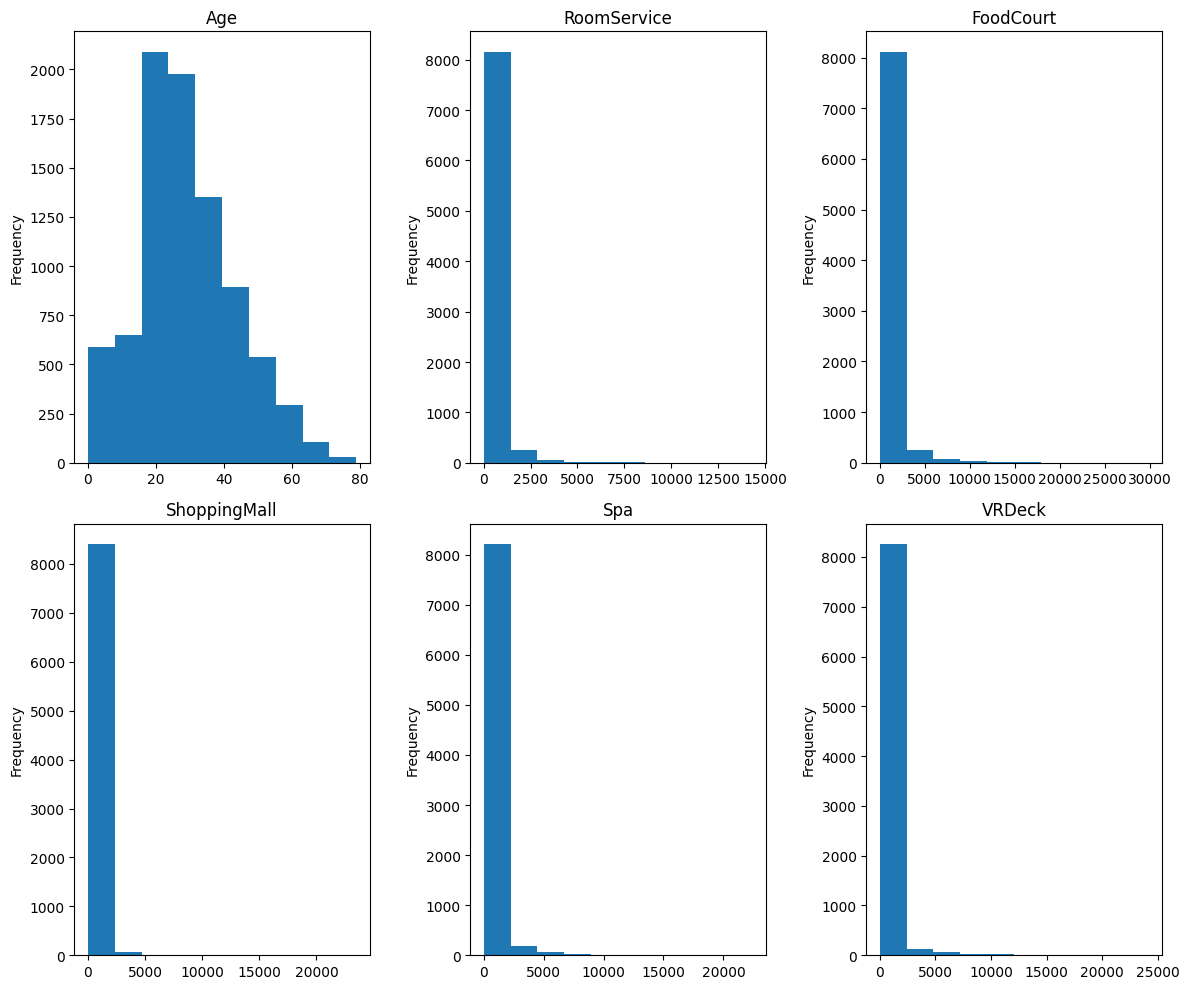

In [15]:
# Create figure and axes
fig, axes = plt.subplots(2, 3, figsize=(12, 10))  

# Plotting
df.Age.plot(kind="hist", ax=axes[0, 0], title="Age")
df.RoomService.plot(kind="hist", ax=axes[0, 1], title="RoomService")
df.FoodCourt.plot(kind="hist", ax=axes[0, 2], title="FoodCourt")
df.ShoppingMall.plot(kind="hist", ax=axes[1, 0], title="ShoppingMall")
df.Spa.plot(kind="hist", ax=axes[1, 1], title="Spa")
df.VRDeck.plot(kind="hist", ax=axes[1, 2], title="VRDeck")

plt.tight_layout()
plt.show()

now we can start building the preprocessing pipeline, so that we can apply the same to the test set

# Preprocessing

In [16]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

In [17]:
train_df = pd.read_csv("train.csv")

In [18]:
def cabin_feature_extractor(X):
    deck = X['Cabin'].str[0]  
    side = X['Cabin'].str[-1]  
    return pd.DataFrame({'Deck': deck, 'Side': side})

In [19]:
cat_transformer = Pipeline([
    ("feature_creater", FunctionTransformer(cabin_feature_extractor, validate=False)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore",drop="if_binary"))
])

In [20]:
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [21]:
preprocessor = ColumnTransformer([
    ("num_preproc", num_transformer, ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']),
    ("cat_preproc", cat_transformer, ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP'])
])

In [22]:
preprocessor

ColumnTransformer(transformers=[('num_preproc',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('cat_preproc',
                                 Pipeline(steps=[('feature_creater',
                                                  FunctionTransformer(func=<function cabin_feature_extractor at 0x16bcc3be0>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['HomePlanet', 'CryoSleep', 'Cabin',
                                  'Destination', 'VIP'])])

# Training and evaluating a model

establish a simple baseline model:

In [23]:
y = train_df.Transported

In [24]:
from sklearn.model_selection import cross_val_score, train_test_split

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
def init_pipeline(model):
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("estimator", model)
    ])
    #print(pipeline)
    return pipeline

In [27]:
pipe = init_pipeline(LogisticRegression())

In [28]:
cross_val_score(pipe,train_df,y,scoring="accuracy")

array([0.76480736, 0.77113283, 0.78780909, 0.79401611, 0.783084  ])

now we try more sophisticated models and grid search for best parameters:

In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
pipe = init_pipeline(DecisionTreeClassifier())
cross_val_score(pipe,train_df,y,scoring="accuracy")

array([0.70902818, 0.72282921, 0.73433007, 0.74510932, 0.73475259])

In [32]:
param_grid = {
    'estimator__min_samples_leaf' : [2, 10, 20, 50],
    'estimator__max_depth': [None, 10, 20, 50],
    'estimator__min_samples_split': [2, 5, 10, 20],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=50,  
    cv=5,       
    random_state=42,
    n_jobs=-1
)

search.fit(train_df, y)

print("Best Parameters:", search.best_params_)
print("Best Score:", search.best_score_)

Best Parameters: {'estimator__min_samples_split': 20, 'estimator__min_samples_leaf': 50, 'estimator__max_depth': 10}
Best Score: 0.7737280727585063


In [33]:
from sklearn.svm import SVC

In [34]:
pipe = init_pipeline(SVC())
cross_val_score(pipe,train_df,y,scoring="accuracy")

array([0.77515814, 0.78205865, 0.786659  , 0.80897583, 0.79516686])

In [35]:
param_grid = {
    'estimator__C' : [0.01, 0.1, 1, 10],
    'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'estimator__degree': [2, 3],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=50,  
    cv=5,       
    random_state=42,
    n_jobs=-1
)

search.fit(train_df, y)

print("Best Parameters:", search.best_params_)
print("Best Score:", search.best_score_)

/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'estimator__kernel': 'rbf', 'estimator__degree': 2, 'estimator__C': 10}
Best Score: 0.7901776148746252


In [36]:
from xgboost import XGBClassifier

In [37]:
pipe = init_pipeline(XGBClassifier())
cross_val_score(pipe,train_df,y,scoring="accuracy")

array([0.76653249, 0.7826337 , 0.7947096 , 0.79804373, 0.783084  ])

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
pipe = init_pipeline(RandomForestClassifier())
cross_val_score(pipe,train_df,y,scoring="accuracy")

array([0.76710753, 0.77343301, 0.76940771, 0.79976985, 0.77905639])

In [40]:
param_grid = {
    'estimator__n_estimators' : [100, 200, 500, 1000],
    'estimator__criterion': ["gini", "entropy", "log_loss"],
    'estimator__min_samples_split': [2, 5, 10, 20],
    'estimator__min_samples_leaf': [2, 5, 10, 20],
    'estimator__max_features': ["sqrt", "log2", None]
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=50,  
    cv=5,       
    random_state=42,
    n_jobs=-1
)

search.fit(train_df, y)

print("Best Parameters:", search.best_params_)
print("Best Score:", search.best_score_)

/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'estimator__n_estimators': 100, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 5, 'estimator__max_features': 'sqrt', 'estimator__criterion': 'log_loss'}
Best Score: 0.7933995107170437


# 2nd try

let's 
- impute the spendings differently
- impute CryoSleep depending on spendings

In [42]:
spendings_features = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

In [43]:
for feature in spendings_features: 
    print(len(df[df.CryoSleep == True][df[feature] > 0]))

0
0
0
0
0


/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_52968/2499983467.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(df[df.CryoSleep == True][df[feature] > 0]))


i.e. no spendings if people where sleeping. now we treat the other way around:

In [44]:
df['Spendings'] = df[spendings_features].sum(axis=1, min_count=1)

in the following rows, CryoSleep needs to be imputed with True:

In [46]:
df[df.CryoSleep.isna() == True][df.Spendings == 0]

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_52968/1895136010.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.CryoSleep.isna() == True][df.Spendings == 0]


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side,Spendings
PassengerId,,,,,,,,,,,,,,,
0099_02,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,True,G,P,0.0
0115_01,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,True,F,P,0.0
0198_01,Earth,NaN,G/30/P,PSO J318.5-22,52.0,False,0.0,0.0,0.0,0.0,0.0,True,G,P,0.0
0290_03,Europa,NaN,B/7/S,TRAPPIST-1e,43.0,False,0.0,0.0,0.0,0.0,0.0,True,B,S,0.0
0433_01,Europa,NaN,B/20/P,55 Cancri e,27.0,False,0.0,0.0,0.0,0.0,0.0,True,B,P,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9076_01,Earth,NaN,G/1461/S,TRAPPIST-1e,32.0,False,0.0,0.0,0.0,0.0,0.0,False,G,S,0.0
9193_01,Earth,NaN,G/1483/S,PSO J318.5-22,35.0,False,0.0,0.0,0.0,0.0,0.0,False,G,S,0.0
9197_01,Europa,NaN,C/308/P,55 Cancri e,44.0,False,0.0,0.0,0.0,0.0,0.0,True,C,P,0.0


in the following rows, CryoSleep needs to be imputed with False:

In [47]:
df[df.Spendings > 0][df.CryoSleep.isna() == True]

/var/folders/_y/_w83gnx12c1brw3yy2nbv91m0000gn/T/ipykernel_52968/3788376794.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.Spendings > 0][df.CryoSleep.isna() == True]


,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side,Spendings
PassengerId,,,,,,,,,,,,,,,
0105_01,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,False,F,P,703.0
0110_02,Europa,NaN,B/5/P,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,0.0,1687.0,False,B,P,2018.0
0173_01,Earth,NaN,E/11/S,TRAPPIST-1e,58.0,False,0.0,985.0,0.0,5.0,0.0,True,E,S,990.0
0241_01,Europa,NaN,E/11/P,55 Cancri e,33.0,False,0.0,1249.0,0.0,4812.0,1116.0,False,E,P,7177.0
0348_02,Mars,NaN,NaN,TRAPPIST-1e,36.0,False,520.0,0.0,1865.0,0.0,0.0,True,None,None,2385.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8993_01,Earth,NaN,F/1844/P,PSO J318.5-22,27.0,False,32.0,8.0,5.0,588.0,18.0,False,F,P,651.0
9031_01,Earth,NaN,G/1455/S,TRAPPIST-1e,51.0,False,0.0,0.0,689.0,0.0,32.0,False,G,S,721.0
9170_01,Earth,NaN,E/587/P,TRAPPIST-1e,33.0,False,1060.0,403.0,1.0,0.0,145.0,False,E,P,1609.0


fancy way did not work - here is the hardcode solution:

In [72]:
train_df['Spendings'] = train_df[spendings_features].sum(axis=1, min_count=1)

In [74]:
train_df['CryoSleep'] = np.where(train_df['Spendings'] == 0, True, False)

In [77]:
train_df['CryoSleep'].isna().sum()

0

In [78]:
train_df.loc[train_df['CryoSleep'] == True, spendings_features] = 0

with this done, we setup a the preprocessor pipeline:

In [80]:
cat_transformer = Pipeline([
    ("feature_creater", FunctionTransformer(cabin_feature_extractor, validate=False)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore",drop="if_binary"))
])
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

In [81]:
preprocessor = ColumnTransformer([
    ("num_preproc", num_transformer, ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']),
    ("cat_preproc", cat_transformer, ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP'])
])

and repeat the model training and evaluation:

In [83]:
pipe = init_pipeline(DecisionTreeClassifier())
cross_val_score(pipe,train_df,y,scoring="accuracy")

array([0.71707878, 0.706728  , 0.74353076, 0.75086306, 0.73130035])

In [84]:
param_grid = {
    'estimator__min_samples_leaf' : [2, 10, 20, 50],
    'estimator__max_depth': [None, 10, 20, 50],
    'estimator__min_samples_split': [2, 5, 10, 20],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=50,  
    cv=5,       
    random_state=42,
    n_jobs=-1
)

search.fit(train_df, y)

print("Best Parameters:", search.best_params_)
print("Best Score:", search.best_score_)

Best Parameters: {'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 50, 'estimator__max_depth': 20}
Best Score: 0.7776382336845574


In [85]:
from sklearn.svm import SVC

In [86]:
pipe = init_pipeline(SVC())
cross_val_score(pipe,train_df,y,scoring="accuracy")

array([0.78090857, 0.78435883, 0.78723404, 0.81012658, 0.79689298])

In [87]:
param_grid = {
    'estimator__C' : [0.01, 0.1, 1, 10],
    'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'estimator__degree': [2, 3],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=50,  
    cv=5,       
    random_state=42,
    n_jobs=-1
)

search.fit(train_df, y)

print("Best Parameters:", search.best_params_)
print("Best Score:", search.best_score_)

/Users/user/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'estimator__kernel': 'rbf', 'estimator__degree': 2, 'estimator__C': 10}
Best Score: 0.7951245077558031


In [88]:
from xgboost import XGBClassifier

In [89]:
pipe = init_pipeline(XGBClassifier())
cross_val_score(pipe,train_df,y,scoring="accuracy")

array([0.77630822, 0.77918344, 0.79240943, 0.79689298, 0.78135788])

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
pipe = init_pipeline(RandomForestClassifier())
cross_val_score(pipe,train_df,y,scoring="accuracy")

array([0.76883266, 0.76940771, 0.7826337 , 0.79401611, 0.78883774])

In [92]:
param_grid = {
    'estimator__n_estimators' : [100, 200, 500, 1000],
    'estimator__criterion': ["gini", "entropy", "log_loss"],
    'estimator__min_samples_split': [2, 5, 10, 20],
    'estimator__min_samples_leaf': [2, 5, 10, 20],
    'estimator__max_features': ["sqrt", "log2", None]
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_grid,
    n_iter=50,  
    cv=5,       
    random_state=42,
    n_jobs=-1
)

search.fit(train_df, y)

print("Best Parameters:", search.best_params_)
print("Best Score:", search.best_score_)

Best Parameters: {'estimator__n_estimators': 200, 'estimator__min_samples_split': 20, 'estimator__min_samples_leaf': 5, 'estimator__max_features': 'sqrt', 'estimator__criterion': 'gini'}
Best Score: 0.7955850054691961


# Stacking

try to squeeze a bit more performance by stacking the best performers together:

In [106]:
from sklearn.ensemble import VotingClassifier

In [111]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split= 20, min_samples_leaf= 5)
sv = SVC(C=10)
xg = XGBClassifier()

ensemble = VotingClassifier(
    estimators = [("rf", rf),("sv", sv),("xg",xg)]
)

In [112]:
pipe = init_pipeline(ensemble)
cross_val_score(pipe,train_df,y,scoring="accuracy")

array([0.78895917, 0.79528465, 0.7947096 , 0.80840046, 0.79516686])

stack one last classifier on top:

In [117]:
from sklearn.ensemble import StackingClassifier

In [137]:
ensemble = StackingClassifier(
    estimators = [("rf", rf),
                  ("sv", sv),
                  ("xg", xg)],
    final_estimator = LogisticRegression())

In [138]:
pipe = init_pipeline(ensemble)
cross_val_score(pipe,train_df,y,scoring="accuracy")

array([0.78953422, 0.79125934, 0.79585969, 0.81703107, 0.79919448])

# Prediction

In [139]:
test_df = pd.read_csv("test.csv")

In [140]:
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


impute CryoSleep and spendings_features by hand ...

In [141]:
test_df['Spendings'] = test_df[spendings_features].sum(axis=1, min_count=1)

In [142]:
test_df['CryoSleep'] = np.where(test_df['Spendings'] == 0, True, False)

In [143]:
test_df.loc[test_df['CryoSleep'] == True, spendings_features] = 0

In [144]:
pipe.fit(train_df,y)
y_pred = pipe.predict(test_df)

In [145]:
predictions = pd.DataFrame( { "PassengerId" : test_df.PassengerId , "Transported" : y_pred })

In [146]:
predictions.to_csv("predictions.csv", index=False)